In [1]:
### IMPORTS ###
# Quantum libraries:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

# Plotting
from matplotlib import pyplot as plt
import plotly

# Other
import os, sys
import time

import copy
import tqdm # Pretty progress bars
from IPython.display import Markdown, display # Better prints
import joblib # Writing and loading
from noisyopt import minimizeSPSA
import optuna # Automatic tuning tool

import multiprocessing

import warnings
warnings.filterwarnings("ignore", message="For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.")

##############

# My functions:
sys.path.insert(0, '../')
import vqe_functions as vqe
import qcnn_functions as qcnn


In [2]:
step_size = 0.03
N = 4
J = 1
l_steps = 10
n_epochs = 3

In [3]:
dev_vqe_mixed = qml.device("default.mixed", wires = N, shots = None)

+--- PARAMETERS ---+
step_size    = 0.03 (Step size of the optimizer)
random_shift = 0.1 (Random shift of parameters of the optimizer)
n_epochs     = 3 (# epochs for the other GSs)
N            = 4 (Number of spins of the system)

+--- CIRCUIT ---+
0: ──RY(0.00)──RX(4.00)──||─╭C───────╭X──||──RY(8.00)───RX(12.00)──||─╭C───────╭X──||──RY(16.00)
1: ──RY(1.00)──RX(5.00)──||─╰X─╭C────│───||──RY(9.00)───RX(13.00)──||─╰X─╭C────│───||──RY(17.00)
2: ──RY(2.00)──RX(6.00)──||────╰X─╭C─│───||──RY(10.00)──RX(14.00)──||────╰X─╭C─│───||──RY(18.00)
3: ──RY(3.00)──RX(7.00)──||───────╰X─╰C──||──RY(11.00)──RX(15.00)──||───────╰X─╰C──||──RY(19.00)

───RX(20.00)──||─╭C───────╭X──||──RY(24.00)──RX(28.00)─┤ ╭<𝓗>
───RX(21.00)──||─╰X─╭C────│───||──RY(25.00)──RX(29.00)─┤ ├<𝓗>
───RX(22.00)──||────╰X─╭C─│───||──RY(26.00)──RX(30.00)─┤ ├<𝓗>
───RX(23.00)──||───────╰X─╰C──||──RY(27.00)──RX(31.00)─┤ ╰<𝓗>

Preparing states:


100%|█████████████████████████████████████████████| 4/4 [00:02<00:00,  1.66it/s]


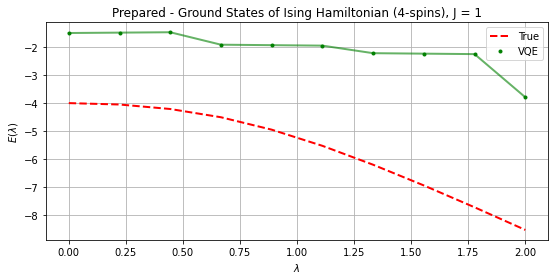

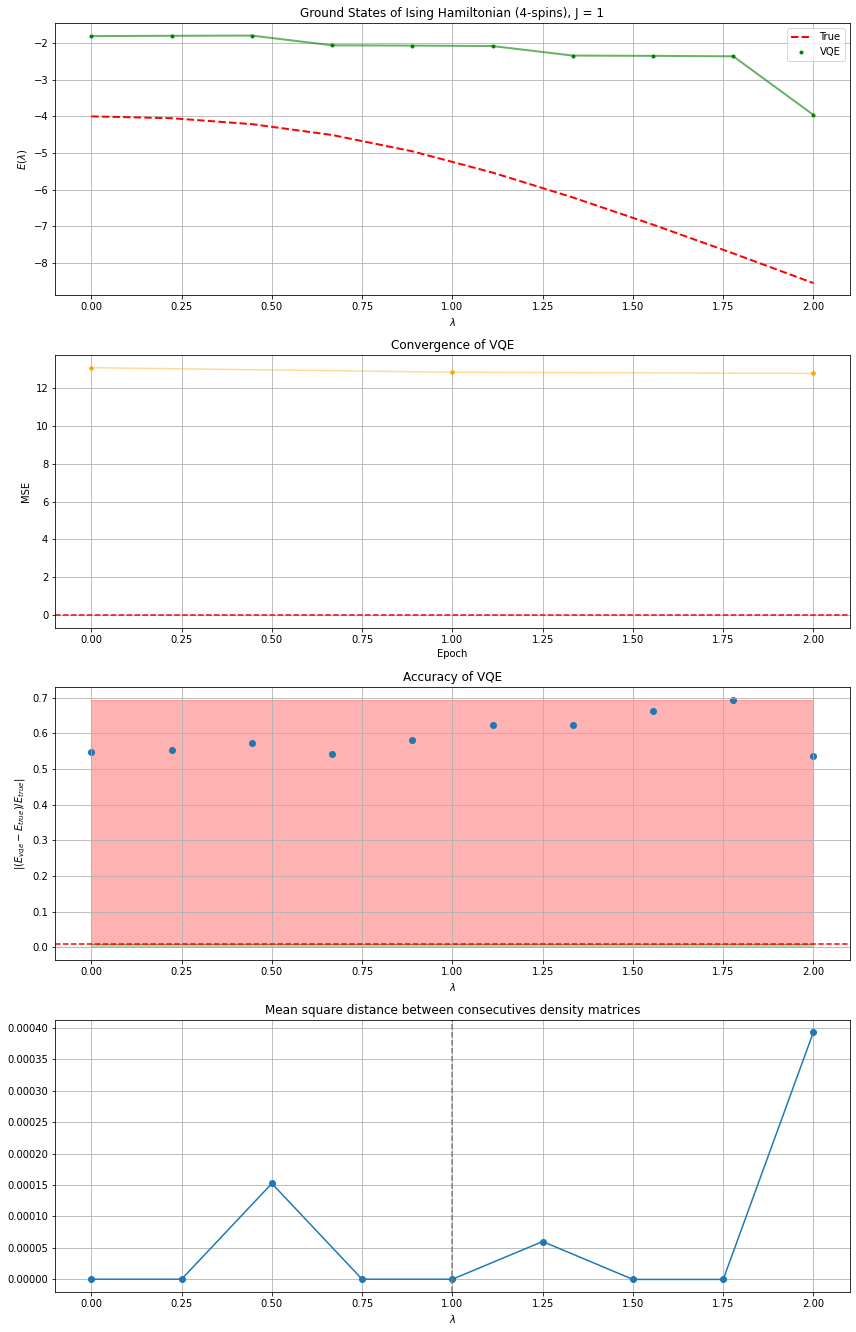

In [4]:
_ = vqe.train(step_size, n_epochs, N, J, l_steps, dev_vqe_mixed, vqe.vqe_circuit, optimizer = 'spsa', random_shift = 0.1, p_noise = 0, p_noise_ent = 0, 
            circuit = True, plots = True, prepare_states = True, preplots = True, prep_step_size = 0.05, prep_epochs = 1, parameter_info = True)

In [5]:
#   _    
#  / |   
#  | |   
#  | |_  
#  |_(_) 

def num_params_qcnn(N):
    '''
    N = number of wires (spins)
    To evaluate the number of parameters needed for the qcnn
    a recursive function is needed:
    '''
    n_params = 0
    # While the number of wires is more than 1s
    while(N > 1):
        # Convolution
        n_params += 3*N
        # Pooling 
        n_params += 2*(N//2) + N%2
        # Reduce number of wires due to pooling
        N = N // 2 + N % 2
    
    # Last RY gate
    n_params += 1
    
    return n_params

#  ____     
# |___ \    
#   __) |   
#  / __/ _  
# |_____(_) Circuit functions

def qcnn_convolution(active_wires, params, N, p_index, conv_noise = 0):
    '''
    Convolution block for the QCNN
    
    RX--RY--o--RX---------
            | 
    RX--RY--x------o--RX--
                   |
    RX--RY--o--RX--x------
            | 
    RX--RY--x------o--RX--
                   |
    RX--RY--o--RX--x------
            | 
    RX--RY--x---------RX--
    
    '''
    
    # Check if the current number of wires is odd
    # it will be needed later.
    isodd = True if len(active_wires) % 2 != 0  else False
    
    noise = True
    if conv_noise == 0: noise = False # Remove BitFlip and PhaseFlip if we are not using default.mixed
    
    # Convolution:
    for wire in active_wires:
        qml.RX(params[p_index], wires = int(wire) )
        p_index = p_index + 1
        
        if noise: qml.PhaseFlip(conv_noise, wires = int(wire) ); qml.BitFlip(conv_noise, wires = int(wire) )
        
    # ---- > Establish entanglement: odd connections
    for wire, wire_next in zip(active_wires[0::2], active_wires[1::2]):
        qml.CNOT(wires = [int(wire), int(wire_next)])
        qml.RX(params[p_index], wires = int(wire) )
        p_index = p_index + 1
        
        if noise: qml.PhaseFlip(conv_noise, wires = int(wire) ); qml.BitFlip(conv_noise, wires = int(wire) )
    
    # ---- > Establish entanglement: even connections
    for wire, wire_next in zip(active_wires[1::2], active_wires[2::2]):
        qml.CNOT(wires = [int(wire), int(wire_next)])
        qml.RX(params[p_index], wires = int(wire) )
        p_index = p_index + 1
        
        if noise: qml.PhaseFlip(conv_noise, wires = int(wire) ); qml.BitFlip(conv_noise, wires = int(wire) )
        
    qml.RX(params[p_index], wires = N-1)
    p_index = p_index + 1
    
    if noise: qml.PhaseFlip(conv_noise, wires = int(N - 1) ); qml.BitFlip(conv_noise, wires = int(N - 1) )

    return p_index
        
def qcnn_pooling(active_wires, params, N, p_index, pool_noise = 0):
    '''
    Pooling block for the QCNN
    
    --MEAS--(=0)--(=1)
             |     |
    ---------RY----RZ----
    
    '''
    # Pooling:
    isodd = True if len(active_wires) % 2 != 0  else False
    
    noise = True
    if pool_noise == 0: noise = False # Remove BitFlip and PhaseFlip if we are not using default.mixed
    
    for wire_meas, wire_next in zip(active_wires[0::2], active_wires[1::2]):
        m_0 = qml.measure(int(wire_meas) )
        qml.cond(m_0 ==0, qml.RY)(params[p_index], wires=int(wire_next) )
        qml.cond(m_0 ==1, qml.RY)(params[p_index+1], wires=int(wire_next) )
        p_index = p_index + 2
        
        if noise: qml.PhaseFlip(pool_noise, wires = int(wire_next) ); qml.BitFlip(pool_noise, wires = int(wire_next) )
        
        # Removing measured wires from active_wires:
        active_wires = np.delete(active_wires, np.where(active_wires == wire_meas) ) 
    # ---- > If the number of wires is odd, the last wires is not pooled
    #        so we apply a Z gate
    if isodd:
        qml.RZ(params[p_index], wires = N-1)
        p_index = p_index + 1
        
        if noise: qml.PhaseFlip(pool_noise, wires = N - 1 ); qml.BitFlip(pool_noise, wires = N - 1 )
        
    return p_index, active_wires

def qcnn_circ(params_vqe, vqe_shift_invariance, params, N, vqe_conv_noise = 0, vqe_rot_noise = 0, qcnn_conv_noise = 0, qcnn_pool_noise = 0):
    '''
    Building function for the circuit:
          VQE(params_vqe) + QCNN(params)
    '''
        
    # Wires that are not measures (through pooling)
    active_wires = np.arange(N)
    
    # Input: State through VQE
    vqe_circuit(N, params_vqe, vqe_shift_invariance, p_noise = vqe_rot_noise, p_noise_ent = vqe_conv_noise)
    
    qml.Barrier()
    
    # Index of the parameter vector
    p_index = 0
    
    while(len(active_wires) > 1):
        p_index = qcnn_convolution(active_wires, params, N, p_index, conv_noise = qcnn_conv_noise)
        qml.Barrier()
        p_index, active_wires = qcnn_pooling(active_wires, params, N, p_index, pool_noise = qcnn_pool_noise)
        qml.Barrier()
        p_index = qcnn_convolution(active_wires, params, N, p_index, conv_noise = qcnn_conv_noise)
        qml.Barrier()
        p_index, active_wires = qcnn_pooling(active_wires, params, N, p_index, pool_noise = qcnn_pool_noise)
        qml.Barrier()
    
    # Final Y rotation
    qml.RY(params[p_index], wires = N-1)
    if qcnn_pool_noise > 0: qml.PhaseFlip(qcnn_pool_noise, wires = N - 1 ); qml.BitFlip(qcnn_pool_noise, wires = N - 1 )

In [14]:
drawer = qml.draw(density_matrices)
print(drawer(np.arange(100), N, 0) )

0: ──RY(0.00)──RX(4.00)──||─╭C───────╭X──||──RY(8.00)───RX(12.00)──||─╭C───────╭X──||──RY(16.00)
1: ──RY(1.00)──RX(5.00)──||─╰X─╭C────│───||──RY(9.00)───RX(13.00)──||─╰X─╭C────│───||──RY(17.00)
2: ──RY(2.00)──RX(6.00)──||────╰X─╭C─│───||──RY(10.00)──RX(14.00)──||────╰X─╭C─│───||──RY(18.00)
3: ──RY(3.00)──RX(7.00)──||───────╰X─╰C──||──RY(11.00)──RX(15.00)──||───────╰X─╰C──||──RY(19.00)

───RX(20.00)──||─╭C───────╭X──||──RY(24.00)──RX(28.00)─┤  State
───RX(21.00)──||─╰X─╭C────│───||──RY(25.00)──RX(29.00)─┤  State
───RX(22.00)──||────╰X─╭C─│───||──RY(26.00)──RX(30.00)─┤  State
───RX(23.00)──||───────╰X─╰C──||──RY(27.00)──RX(31.00)─┤  State


In [7]:
vqe_e, errs, thetas, ys = vqe.mptrain(0.03, 1000, N, J, 100, vqe_cost_fn_mixed, density_matrices, optimizer = 'Adam',
                                             shift_invariance = shift_invariance, p_noise = 0, p_noise_ent = 0,
                                             circuit = True, plots = True, prepare_states = True, preplots = True,
                                             prep_step_size = 0.05, cutoff_value = 0.005)

vqe_data_x = thetas 
vqe_data_y = ys
    
vqe_data = []
for i in range(len(vqe_data_x)):
    vqe_data.append((vqe_data_x[i],vqe_data_y[i]))
    
vqe_data = np.array(vqe_data)

joblib.dump(vqe_data, '../vqe_states_job/vqe_params_0noise.job')


***Parameters:***

step_size    = 0.03 (Step size of the optimizer)
random_shift = 0 (Random shift of parameters of the optimizer)
n_epochs     = 1000 (# epochs for the other GSs)
N            = 4 (Number of spins of the system)


***Circuit:***

0: ──RY(0.00)──RX(0.00)──||─╭C───────╭X──||──RY(0.00)──RX(0.00)──||─╭C───────╭X──||──RY(0.00)
1: ──RY(0.00)──RX(0.00)──||─╰X─╭C────│───||──RY(0.00)──RX(0.00)──||─╰X─╭C────│───||──RY(0.00)
2: ──RY(0.00)──RX(0.00)──||────╰X─╭C─│───||──RY(0.00)──RX(0.00)──||────╰X─╭C─│───||──RY(0.00)
3: ──RY(0.00)──RX(0.00)──||───────╰X─╰C──||──RY(0.00)──RX(0.00)──||───────╰X─╰C──||──RY(0.00)

───RX(0.00)──||─╭C───────╭X──||──RY(0.00)──RX(0.00)─┤ ╭<𝓗>
───RX(0.00)──||─╰X─╭C────│───||──RY(0.00)──RX(0.00)─┤ ├<𝓗>
───RX(0.00)──||────╰X─╭C─│───||──RY(0.00)──RX(0.00)─┤ ├<𝓗>
───RX(0.00)──||───────╰X─╰C──||──RY(0.00)──RX(0.00)─┤ ╰<𝓗>

Preparing states:


  0%|          | 0/34 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
## Load data:
data = joblib.load('../vqe_states_job/vqe_params_0noise.job')

print('Size of Data Set: {0}'.format(len(data)))

train_index = np.sort(np.random.choice(np.arange(len(data)), size=int(0.8*len(data)), replace=False ))
test_index = []

X_train, Y_train = [], []
X_test, Y_test   = [], []

for i in range(len(data)): 
    if i in train_index:
        X_train.append(data[i][0])
        Y_train.append(data[i][1])
    else:
        test_index.append(i)
        X_test.append(data[i][0])
        Y_test.append(data[i][1])
        
#X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
#X_test, Y_test   = jnp.array(X_test), jnp.array(Y_test)

print('______________________________')
print('Size of Training Set: {0}'.format(np.shape(X_train)[0]))
print('Size of Test Set    : {0}'.format(np.shape(X_test)[0]))


Size of Data Set: 100
______________________________
Size of Training Set: 80
Size of Test Set    : 20


In [16]:
N = 4
J = 1
shift_invariance = 0

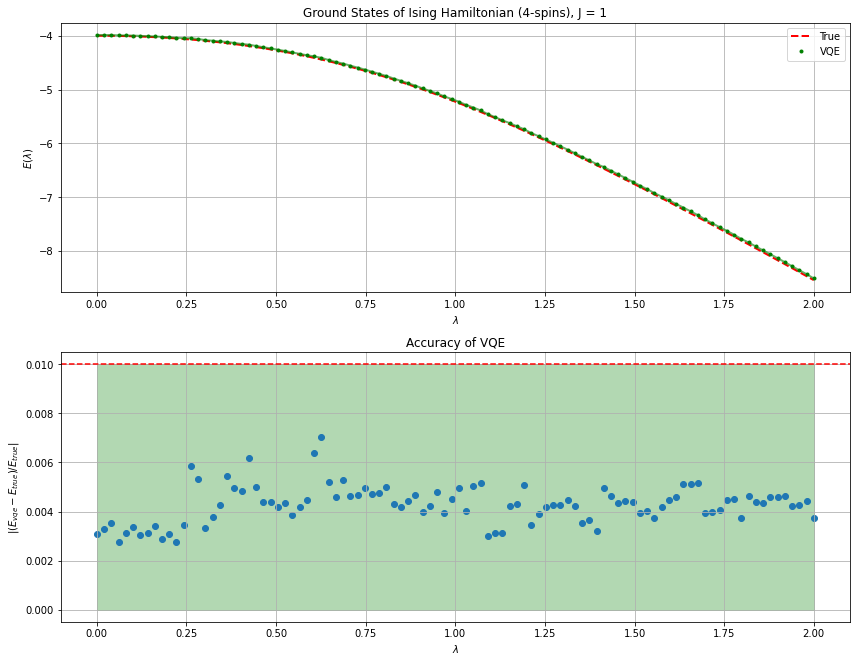

In [17]:
vqe.show_train_plots(data, N, J, vqe_cost_fn_mixed, 0)

In [18]:
'''X_train, Y_train = [], []
sub_train_index = np.random.choice(train_index, 60, replace = False)
for i in range(len(data)): 
    if i in sub_train_index:
        X_train.append(data[i][0])
        Y_train.append(data[i][1])
        '''

'X_train, Y_train = [], []\nsub_train_index = np.random.choice(train_index, 60, replace = False)\nfor i in range(len(data)): \n    if i in sub_train_index:\n        X_train.append(data[i][0])\n        Y_train.append(data[i][1])\n        '

(-0.5, 1.5)

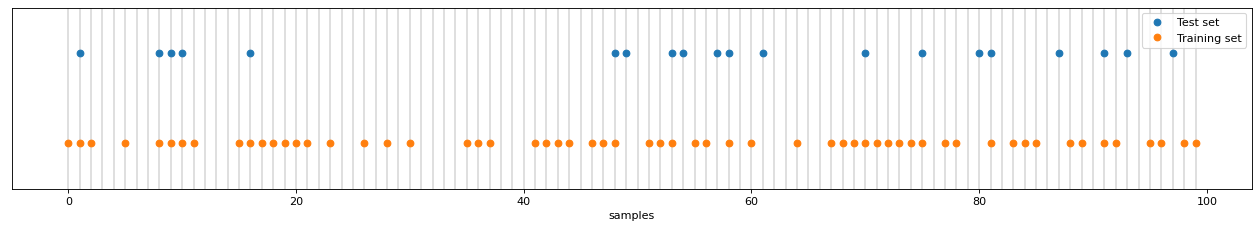

In [19]:
plt.figure(figsize=(20, 3), dpi=80)
for i in range(len(data)):
    plt.axvline(x=i,color ='gray', alpha = 0.3)
plt.plot(test_index, [1]*len(test_index), 'o', label = 'Test set')
plt.plot(sub_train_index, [0]*len(sub_train_index), 'o', label = 'Training set')
plt.legend()
plt.yticks([])
plt.xlabel('samples')
plt.ylim(-.5,1.5)


In [20]:
# Training function
def train(epochs, lr, r_shift, vqe_shift_invariance, N, vqe_conv_noise, vqe_rot_noise, qcnn_conv_noise, qcnn_pool_noise,
          qcnn_circuit, X_train, Y_train, X_test = [], Y_test = [], plot = True, info = True, batch_size = 32):
    
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_test, Y_test = np.array(X_test), np.array(Y_test)    
    
    if info:
        display(Markdown('***Parameters:***'))
        print('a factor   = {0} (\'a\' coefficient of the optimizer)'.format(lr))
        print('r_shift    = {0} (c coefficient of the optimizer)'.format(r_shift))
        print('epochs     = {0} (# epochs for learning)'.format(epochs))
        print('N          = {0} (Number of spins of the system)'.format(N))
    
    # Initialize parameters randomly
    params = np.array( [np.pi/2]*24 )
    
    # Cost function to minimize, returning the cross-entropy of the training set
    # Additionally it computes the accuracy of the training and test set 
    # (every 10 epochs)
    
    def update(params, seed = 0):
        global get_c_entropy
    
        np.random.seed(seed=seed)
        sub_train_idx = np.random.choice(np.arange(len(X_train)), batch_size, replace = False)
        X_train_sub = X_train[sub_train_idx]
        Y_train_sub = Y_train[sub_train_idx]
        
        def get_c_entropy(idx):
            prediction = qcnn_circuit(X_train_sub[idx], vqe_shift_invariance, params, N,
                                      vqe_conv_noise, vqe_rot_noise, qcnn_conv_noise, qcnn_pool_noise)
            
            # Cross entropy rule
            return - (Y_train_sub[idx] * np.log(prediction[Y_train_sub[idx]]) + (1 - Y_train_sub[idx]) * np.log(1 - prediction[1 - Y_train_sub[idx]]) )
        
        p = multiprocessing.Pool()
        with p: rdata = p.map(get_c_entropy, np.arange(len(X_train_sub)) )
        
        rdata = np.array(rdata)
        
        return np.sum(rdata)
    
    def callback(params):
        global get_c_entropy_train, get_c_entropy_test
        
        def get_c_entropy_train(idx):
            prediction = qcnn_circuit(X_train[idx], vqe_shift_invariance, params, N,
                                      vqe_conv_noise, vqe_rot_noise, qcnn_conv_noise, qcnn_pool_noise)
            
            if np.argmax( prediction ) == Y_train[idx]:
                correct = 1  
            else:
                correct = 0
            
            # Cross entropy rule
            return -(Y_train[idx] * np.log(prediction[Y_train[idx]]) + (1 - Y_train[idx]) * np.log(1 - prediction[1 - Y_train[idx]]) ), correct
        
        def get_c_entropy_test(idx):
            prediction = qcnn_circuit(X_test[idx], vqe_shift_invariance, params, N,
                                      vqe_conv_noise, vqe_rot_noise, qcnn_conv_noise, qcnn_pool_noise)
            
            if np.argmax( prediction ) == Y_test[idx]:
                correct = 1  
            else:
                correct = 0
                
            # Cross entropy rule
            return -( Y_test[idx] * np.log(prediction[Y_test[idx]]) + (1 - Y_test[idx]) * np.log(1 - prediction[1 - Y_test[idx]]) ), correct
        
        p = multiprocessing.Pool()
        with p: rdata = p.map(get_c_entropy_train, np.arange(len(X_train)) )
        
        rdata = np.array(rdata)
        loss_history.append(np.sum(rdata[:,0]) )
        accuracy_history.append(100*np.sum(rdata[:,1]/len(X_train) ) )
        
        if len(accuracy_history)%10 == 0:
            p = multiprocessing.Pool()
            with p: rdata = p.map(get_c_entropy_test, np.arange(len(X_test)) )
            rdata = np.array(rdata)
            loss_history_test.append(np.sum(rdata[:,0]) )
            accuracy_history_test.append(100*np.sum(rdata[:,1]/len(X_test) ) )
            
        pbar.update(1)
        pbar.set_description('Cost: {0} | Accuracy: {1}'.format(np.round(loss_history[-1],5), np.round(accuracy_history[-1],2) )  )
        
    loss_history = []
    accuracy_history = []
    loss_history_test = []
    accuracy_history_test = []
    
    #with tqdm(total=epochs) as pbar:
    if info:
        pbar = tqdm(total = epochs)
    else:
        pbar = False
    
    res = minimizeSPSA(update,
                       x0=params,
                       niter=epochs,
                       paired=True,
                       c=r_shift,
                       a=lr,
                       callback = callback)
    
    # Update final parameterss
    params = res.x
    
    if plot:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(len(loss_history)), np.asarray(loss_history), label = 'Training Loss')
       #if len(X_test) > 0:
            #plt.plot(np.arange(steps), np.asarray(loss_history_test)/len(X_test), color = 'green', label = 'Test Loss')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title('Loss history')
        plt.ylabel('Average Cross entropy')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend()
        
        plt.figure(figsize=(15,4))
        plt.plot(np.arange(len(accuracy_history)), accuracy_history, color='orange', label = 'Training Accuracy')
        if len(X_test) > 0:
            plt.plot(np.arange(len(accuracy_history_test))*10, accuracy_history_test, color='violet', label = 'Test Accuracy')
        plt.axhline(y=100, color='r', linestyle='--')
        plt.title('Accuracy')
        plt.ylabel('%')
        plt.xlabel('Epoch')
        plt.grid(True)
        plt.legend()
        
    return loss_history, accuracy_history, params

In [21]:
@qml.qnode(dev_vqe_mixed)
def qcnn_circuit(params_vqe, vqe_shift_invariance, params, N, vqe_conv_noise = 0, vqe_rot_noise = 0, qcnn_conv_noise = 0, qcnn_pool_noise = 0):
    qcnn_circ(params_vqe, vqe_shift_invariance, params, N, vqe_conv_noise, vqe_rot_noise, qcnn_conv_noise, qcnn_pool_noise)
    
    return qml.probs(wires = N - 1)

In [22]:
drawer = qml.draw(qcnn_circuit)
print(drawer(np.arange(100), 0, np.arange(100), N) )

0: ──RY(0.00)──RX(4.00)──||─╭C───────╭X──||──RY(8.00)───RX(12.00)──||─╭C───────╭X──||──RY(16.00)
1: ──RY(1.00)──RX(5.00)──||─╰X─╭C────│───||──RY(9.00)───RX(13.00)──||─╰X─╭C────│───||──RY(17.00)
2: ──RY(2.00)──RX(6.00)──||────╰X─╭C─│───||──RY(10.00)──RX(14.00)──||────╰X─╭C─│───||──RY(18.00)
3: ──RY(3.00)──RX(7.00)──||───────╰X─╰C──||──RY(11.00)──RX(15.00)──||───────╰X─╰C──||──RY(19.00)

───RX(20.00)──||─╭C───────╭X──||──RY(24.00)──RX(28.00)──||──RX(0.00)─╭C──RX(4.00)───────────────||
───RX(21.00)──||─╰X─╭C────│───||──RY(25.00)──RX(29.00)──||──RX(1.00)─╰X───────────╭C──RX(6.00)──||
───RX(22.00)──||────╰X─╭C─│───||──RY(26.00)──RX(30.00)──||──RX(2.00)─╭C──RX(5.00)─╰X────────────||
───RX(23.00)──||───────╰X─╰C──||──RY(27.00)──RX(31.00)──||──RX(3.00)─╰X──RX(7.00)───────────────||

──╭C─────────╭C──────────||───────────────────────────||────────────────────────||────────────┤       
──╰RY(8.00)──╰RY(9.00)───||──RX(12.00)─╭C──RX(14.00)──||─╭C─────────╭C──────────||────────────┤       
──╭C────

***Parameters:***

a factor   = 0.5 ('a' coefficient of the optimizer)
r_shift    = 1e-06 (c coefficient of the optimizer)
epochs     = 600 (# epochs for learning)
N          = 4 (Number of spins of the system)


  0%|          | 0/600 [00:00<?, ?it/s]

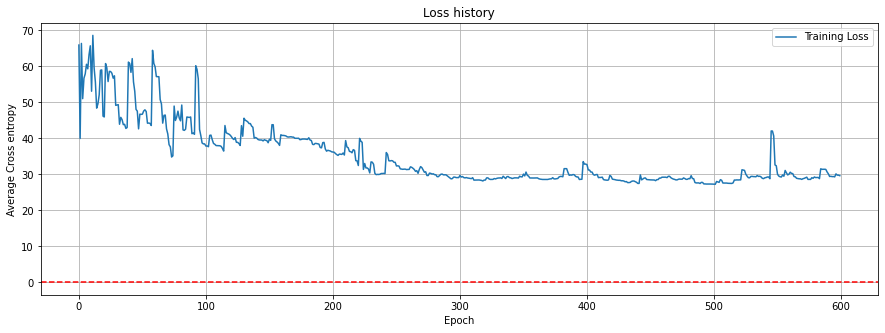

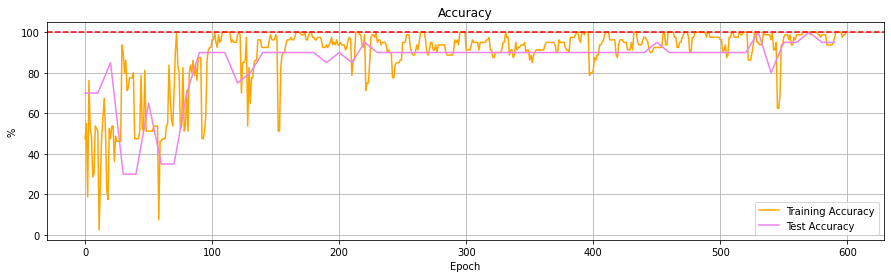

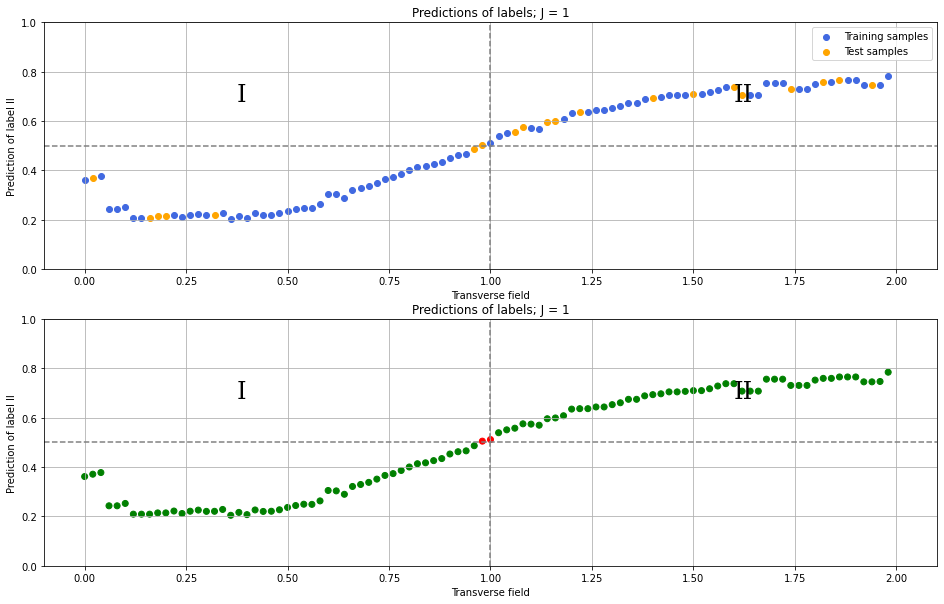

In [23]:
loss_history, accuracy_history, params = train(600, .5, 1e-6, 0, N, 0, 0, 0, 0,
                                                    qcnn_circuit, X_train, Y_train, X_test, Y_test, plot = True, batch_size = 16)
qcnn.plot_results_classification(data, train_index, params, 0, N, qcnn_circuit,
                                vqe_conv_noise = 0, vqe_rot_noise = 0, qcnn_conv_noise = 0, qcnn_pool_noise = 0)

In [ ]:
drawer = qml.draw(qcnn_circuit)
print(drawer([0]*40, 0, [0]*100, N) )

In [ ]:
@qml.qnode(dev_vqe_mixed)
def aaa(params_vqe, N, vqe_shift_invariance = 0 ):
    # Input: State through VQE
    vqe_circuit(N, params_vqe, vqe_shift_invariance)
    return qml.state()

In [ ]:
dist = []
means = []
for i in range(99):
    dist.append(np.real(np.mean( np.square(aaa(data[i][0], 4, 0) - aaa(data[i+1][0], 4, 0)) ) ) )
    means.append(np.real(np.mean(np.square(aaa(data[i+1][0], 4, 0) ))))

In [ ]:
ens = []
for mu in np.linspace(0,2,num=10):
    H = np.real( qml.matrix(qml_build_H(4, float(mu), 1)) )
    eigval, eigvec = np.linalg.eig(H)
    gstate = eigvec[:,np.argmin(eigval)]
    
    ens.append( np.transpose(gstate) @ H @ gstate )

In [ ]:
plt.plot(ens)